In [2]:
import numpy as np
from scipy.linalg import norm as linalg_norm
import scipy.linalg as la
from scipy.stats import norm as stats_norm, gamma
from sklearn.covariance import GraphicalLassoCV
from lib_fun import *  
from MAVE1 import *
from gram_matrix import *
from FOPG import *
from numpy.linalg import pinv,inv 
from scipy.linalg import sqrtm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [ ]:
X = pd.read_csv('mortx.csv',header= None)
Y = pd.read_csv('morty.csv',header=None)

ygram_df = pd.read_csv('mort_ygram.csv', header=None)
ygram_df = ygram_df.iloc[1:, 1:]
ygram = ygram_df.to_numpy()
ygram = np.asarray(ygram, dtype=np.float64)

X = X.to_numpy()
Y = Y.to_numpy()
metric = "Wasserstein"
#scaler = StandardScaler()
#X_normalized = scaler.fit_transform(X)
#X = X_normalized
mean= np.mean(X,axis = 0)
std = np.std(X,axis = 0, ddof =1)

X = (X-mean)/std


n,p = X.shape
neigh = False
d_0 = 3

In [4]:
#GWIRE


Nb = []
    

if not neigh:
    # Neighborhood is unknown
    graphical_lasso_model = GraphicalLassoCV() 
    graphical_lasso_model.fit(X)
    omega = graphical_lasso_model.precision_
        
for j in range(p):
    Ni = np.nonzero(omega[j, :])[0].tolist()
    Nb.append(Ni)
beta_gwire, _ = gwire_cv(X, Y, Nb, metric, d_0, fold=5)

Xb = X@beta_gwire
X2 = np.hstack((Xb, np.ones((n, 1))))

y_pred = np.dot(X2, np.linalg.inv(np.dot(X2.T, X2)).dot(X2.T).dot(Y))

SS_res = np.sum((Y - y_pred)**2)
SS_tot = np.sum((Y - np.mean(Y,axis=0))**2)
R_squared1 = 1 - (SS_res / SS_tot)

# Calculate adjusted R-squared
R_squared_adj = 1 - ((1 - R_squared1) * (n - 1) / (n - p - 1))

# Display the results
print(f'R-squared: {R_squared1}')
print(f'Adjusted R-squared: {R_squared_adj}')


#poly fit

Xpoly = np.hstack([
    np.ones((n, 1)),                # Column of ones
    Xb,                              # Original features
    Xb**2,                            # Squares of the features
    Xb[:, [0]] * Xb[:, [1]],           # Interaction terms
    Xb[:, [0]] * Xb[:, [2]],  
    Xb[:, [1]] * Xb[:, [2]]
     
])


Xpoly_inv = inv(Xpoly.T @ Xpoly)
y_pred = Xpoly @ Xpoly_inv @ Xpoly.T @ Y

# Calculate R-squared
SS_res = np.sum((Y - y_pred)**2)
SS_tot = np.sum((Y - np.mean(Y))**2)
R_squared1 = 1 - (SS_res / SS_tot)

print(f'Poly_R-squared: {R_squared1}')


R-squared: 0.5715274471882208
Adjusted R-squared: 0.5461573618243654
Poly_R-squared: 0.9326868182370102


In [5]:
#FOPG

beta_fopg =FOPG(X,ygram,d_0)
Xb = X@beta_fopg
X2 = np.hstack((Xb, np.ones((n, 1))))

y_pred = np.dot(X2, np.linalg.inv(np.dot(X2.T, X2)).dot(X2.T).dot(Y))

SS_res = np.sum((Y - y_pred)**2)
SS_tot = np.sum((Y - np.mean(Y,axis=0))**2)
R_squared1 = 1 - (SS_res / SS_tot)

# Calculate adjusted R-squared
R_squared_adj = 1 - ((1 - R_squared1) * (n - 1) / (n - p - 1))

# Display the results
print(f'R-squared: {R_squared1}')
print(f'Adjusted R-squared: {R_squared_adj}')


#poly fit

Xpoly = np.hstack([
    np.ones((n, 1)),                # Column of ones
    Xb,                              # Original features
    Xb**2,                            # Squares of the features
    Xb[:, [0]] * Xb[:, [1]],           # Interaction terms
    Xb[:, [0]] * Xb[:, [2]],  
    Xb[:, [1]] * Xb[:, [2]]
     
])

Xpoly_inv = inv(Xpoly.T @ Xpoly)
y_pred = Xpoly @ Xpoly_inv @ Xpoly.T @ Y

# Calculate R-squared
SS_res = np.sum((Y - y_pred)**2)
SS_tot = np.sum((Y - np.mean(Y))**2)
R_squared1 = 1 - (SS_res / SS_tot)

print(f'Poly_R-squared: {R_squared1}')

R-squared: 0.42940375677079046
Adjusted R-squared: 0.39561845289537667
Poly_R-squared: 0.9324203664792404


In [8]:
#Fd_SDR
ygram2 = np.real(sqrtm(ygram))
init = beta_fopg
beta_dcov, _,_ = MAVE1(X.T,ygram2,init)
Xb = X@beta_dcov
X2 = np.hstack((Xb, np.ones((n, 1))))

y_pred = X2@ inv((X2.T@ X2))@(X2.T)@(Y)

SS_res = np.sum((Y - y_pred)**2)
SS_tot = np.sum((Y - np.mean(Y,axis=0))**2)
R_squared1 = 1 - (SS_res / SS_tot)

# Calculate adjusted R-squared
R_squared_adj = 1 - ((1 - R_squared1) * (n - 1) / (n - p - 1))

# Display the results
print(f'R-squared: {R_squared1}')
print(f'Adjusted R-squared: {R_squared_adj}')




# Extend the feature matrix X
Xpoly = np.hstack([
    np.ones((n, 1)),                # Column of ones
    Xb,                              # Original features
    Xb**2,                            # Squares of the features
    Xb[:, [0]] * Xb[:, [1]],           # Interaction terms
    Xb[:, [0]] * Xb[:, [2]],  
    Xb[:, [1]] * Xb[:, [2]]
     
])

# Prediction using polynomial regression
Xpoly_inv = inv(Xpoly.T @ Xpoly)
y_pred = Xpoly @ Xpoly_inv @ Xpoly.T @ Y

# Calculate R-squared
SS_res = np.sum((Y - y_pred)**2)
SS_tot = np.sum((Y - np.mean(Y))**2)
R_squared1 = 1 - (SS_res / SS_tot)

print(f'Poly_R-squared: {R_squared1}')


R-squared: 0.553096509557403
Adjusted R-squared: 0.5266351186759335
Poly_R-squared: 0.9291959816850907


In [9]:
b2= beta_dcov
b2 = np.hstack((b2,np.ones((9,1))))
beta_true = np.hstack((beta_true,np.ones((9,1))))
error3 = linalg_norm(b2@inv(b2.T@b2)@b2.T-beta_true@inv(beta_true.T@beta_true)@beta_true.T)

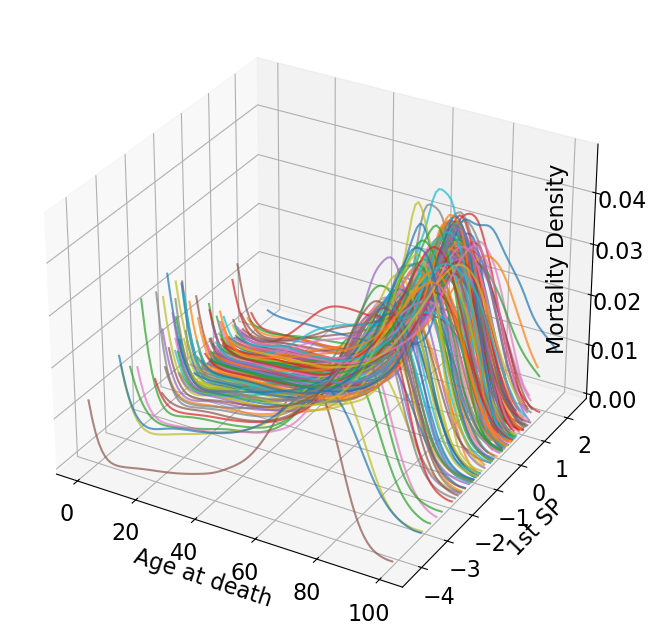

In [14]:
beta_1 = beta_dcov[:,0]
beta_2 = beta_dcov[:,1]
beta_3 = beta_dcov[:,2]
new_x1 = X @ beta_1
new_x2 = X @ beta_2
new_x3 = X @ beta_3
ages = np.linspace(0,100,101)


fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(new_x1)):
    ax.plot(ages, [new_x1[i]] * len(ages), Y[i, :], alpha=0.7)

# Set axis labels
ax.set_xlabel('Age at death', fontsize=16)
ax.set_ylabel('1st SP', fontsize=16)
ax.set_zlabel('')

# Move the z-axis label inside the plot
ax.text2D(0.87, 0.45, 'Mortality Density', transform=ax.transAxes, fontsize=16, rotation=90)
# Increase the size of tick labels
ax.tick_params(axis='both', which='major', labelsize=16)
# Save the plot with high DPI
plt.savefig('mort1.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


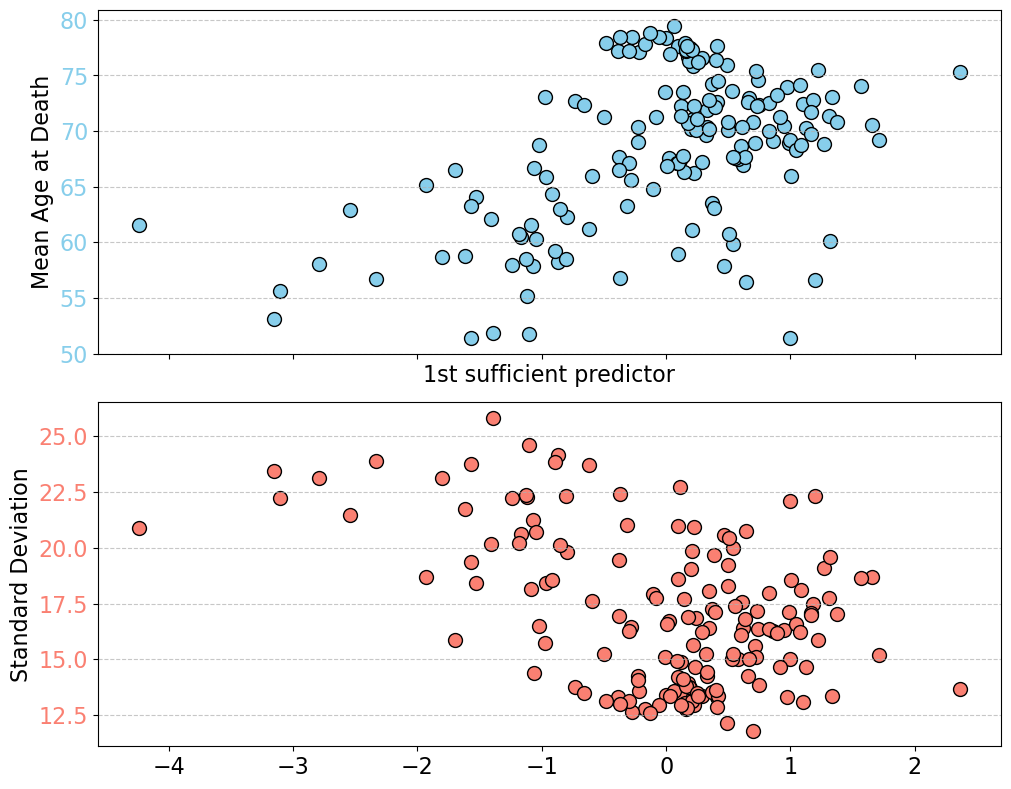

In [15]:
MEAN = np.zeros((n, 1))
SD = np.zeros((n, 1))

for i in range(n):
    deaths = Y[i, :]  # Extract the deaths for country i
    
    # Calculate mean age at death for country i
    mean_age = np.sum(deaths * ages) / np.sum(deaths)
    
    # Calculate variance of ages at death for country i
    variance_age = np.sum(deaths * (ages - mean_age) ** 2) / np.sum(deaths)
    
    # Calculate standard deviation
    sd_age = np.sqrt(variance_age)
    
    # Store the results in MEAN and SD arrays
    MEAN[i] = mean_age
    SD[i] = sd_age

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Subplot 1: Mean Age at Death
ax1.scatter(new_x1, MEAN, color='skyblue', s=100, edgecolor='black')
ax1.set_xlabel('1st sufficient predictor', fontsize=16)
ax1.set_ylabel('Mean Age at Death', fontsize=16)
ax1.tick_params(axis='y', labelcolor='skyblue', labelsize=16)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Subplot 2: Standard Deviation
ax2.scatter(new_x1, SD, color='salmon', s=100, edgecolor='black')
ax2.set_ylabel('Standard Deviation', fontsize=16)
ax2.tick_params(axis='y', labelcolor='salmon', labelsize=16)
ax2.tick_params(axis='x', which='major', labelsize=16)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Save and display
plt.savefig('mort2.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

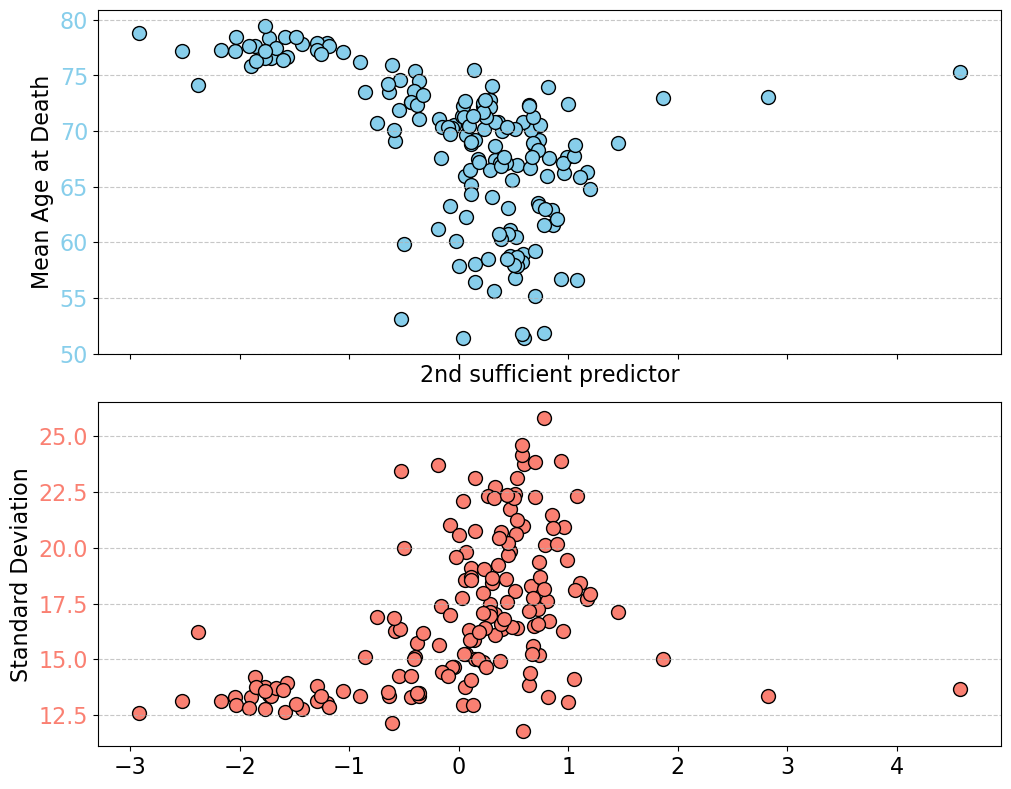

In [16]:
# Create the dot plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Subplot 1: Mean Age at Death
ax1.scatter(new_x2, MEAN, color='skyblue', s=100, edgecolor='black')
ax1.set_ylabel('Mean Age at Death', fontsize=16)
ax1.tick_params(axis='y', labelcolor='skyblue', labelsize=16)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Subplot 2: Standard Deviation
ax2.scatter(new_x2, SD, color='salmon', s=100, edgecolor='black')
ax2.set_ylabel('Standard Deviation', fontsize=16)
ax2.tick_params(axis='y', labelcolor='salmon', labelsize=16)
ax2.tick_params(axis='x', which='major', labelsize=16)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Set the x-axis label in the bottom plot
ax1.set_xlabel('2nd sufficient predictor', fontsize=16)

# Save and display the plot
plt.savefig('mort3.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()
